In [1]:
# Name: example_basic
# Authors: Stephan Meighen-Berger, Kruteesh Desai
# A basic example how to use the package

In [2]:
# imports
from constants import pdm_constants as const
from config import config
from pone_aeff import Aeff
from dm2nu import DM2Nu
from atm_shower import Atm_Shower
from detectors import Detector
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from limit_calc import Limits
from bkgrd_calc import Background
from signal_calc import Signal
from pdm import PDM
from scipy.interpolate import UnivariateSpline
from scipy.stats import chi2
from scipy.stats import *
from pone_aeff import Aeff
import pickle
from matplotlib import rc
def find_nearest(array: np.array, value: float):
    
    """ Returns: index of the nearest vlaue of an array to the given number
    --------------
    idx :  float
    """
    array = np.array(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [3]:
# picture path
PICS = '../pics/'
name=[r'$\nu_{\mu}$', r"$\nu_e$", r"$\nu_{\tau}$"]  # ,r'$\nu_{e}$',r'$\nu_{\tau}$'
# Plotting standards
std_size = 6.  # Size of the plot
fontsize = 15.  # Fontsize in the plot
lw=0.1  # Linewidth
h_length=0.7  # Handle length for the legends
export_dpi = 500  # Dpi for the image export
color_pone='#7570b3'
color_ice='#e7298a'
color_combined='#33a02c'
color_thermal='#1f78b4'
color_unitary='k'
color_4='#1b9e77'
color_6='#d95f02'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [4]:
low_E_sigma = {
                'numu': [0.45, 0.35, 0.25, 0.15],
                'nue': [0.55, 0.45, 0.35, 0.25],
                'nutau': [0.55, 0.45, 0.35, 0.25]},
high_E_sigma = {
                'numu': [0.25, 0.15, 0.10, 0.09],
                'nue': [0.15, 0.12, 0.09, 0.07],
                'nutau': [0.15, 0.12, 0.09, 0.07] }

In [5]:
# Some example settings
#config['atmospheric showers']['interaction model'] = 'SIBYLL2.3c'
#config['atmospheric showers']['theta angles'] = np.linspace(0., 90., 91)|
#config['atmospheric showers']['particles of interest']=['nue']
config['general']['detector'] = 'POne'
config['general']['pone type'] = 'old'
config['general']['density'] = 'NFW'  # 'NFW'
config['general']["channel"] = "All" 
config['pone']['smearing'] = 'unsmeared'
config['pone']['low E sigma'] = {'numu': 0.25,
                                 'nue': 0.45,
                                 'nutau': 0.45}
config['pone']['high E sigma'] = {'numu': 0.15,
                                 'nue': 0.12,
                                 'nutau': 0.12}
#low E sigma': {
#                'numu': [0.45, 0.35, 0.25, 0.15],
#                'nue': [0.55, 0.45, 0.35, 0.25],
#                'nutau': [0.55, 0.45, 0.35, 0.25]},
#            'high E sigma': {
#                'numu': [0.25, 0.15, 0.10, 0.09],
#                'nue': [0.15, 0.12, 0.09, 0.07],
#                'nutau': [0.15, 0.12, 0.09, 0.07]

In [6]:
surface_fluxe = pickle.load(open("../data/" +
                                                   "surf_store_v1.p", "rb"))

In [7]:
pdm = PDM()

POne
pone background
Starting Calculation
False
Finished Calculating Background


/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:362: RuntimeWarning: overflow encountered in multiply
  return A * aa * dd
/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:361: RuntimeWarning: overflow encountered in exp
  dd = np.exp(d_2 / s_in(x)**2)
100%|██████████| 3/3 [00:00<00:00, 22.35it/s]


In [8]:
e_grid = pdm._shower_sim.egrid
e_width = pdm._shower_sim.ewidth

In [9]:
_bkgrd_ice_data = [
                        '../data/icecube_10year_ps/events/IC40_exp.csv',
                        '../data/icecube_10year_ps/events/IC59_exp.csv',
                        '../data/icecube_10year_ps/events/IC79_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_I_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_II_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_III_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_IV_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_V_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_VI_exp.csv',
                        '../data/icecube_10year_ps/events/IC86_VII_exp.csv',
                    ]

In [10]:
e_grid = e_grid
eff_po_15 = pdm._aeff.spl_A15(e_grid)
eff_po_51 = pdm._aeff.spl_A51(e_grid)
eff_po_55 = pdm._aeff.spl_A55(e_grid)

eff_ice = pickle.load(open('/home/kruteesh/Desktop/dm_data_server/eff_area_ice.pkl','rb'))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


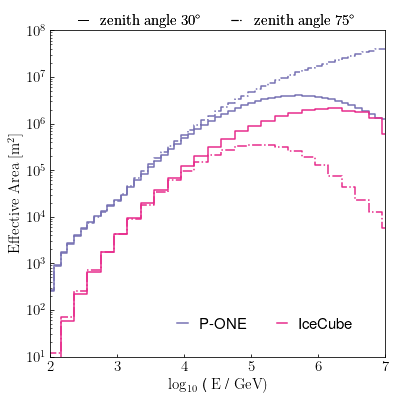

In [11]:
figure, ax1 = plt.subplots(1,1,figsize=(std_size,std_size), sharex=True) 


ax1.step(np.log10(e_grid), eff_po_15, color=color_pone, label=r'P-ONE' )
ax1.step(np.log10(e_grid), eff_ice[30], color=color_ice, label=r'IceCube')
ax1.step(np.log10(e_grid), eff_po_55, color=color_pone, linestyle='-.')
ax1.step(np.log10(e_grid), eff_ice[75], color=color_ice, linestyle='-.')

ax1.set_yscale("log")

ax1.set_xlabel(r'$\log_{10}$ ( $\textrm{E}$ / $ \textrm{GeV} )$ ', fontsize=fontsize)

ax1.set_ylabel(r'$\textrm{Effective Area}$ $[ \textrm{m}^2 ]$', fontsize=fontsize)

ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')



ax1.set_xlim(2, 7)

ax1.set_ylim(1e1,1e8)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=7, bbox_to_anchor=(0.95, +0.1),
                 ncol=2, fontsize=fontsize, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd1)
legend_elements_s = [Line2D([0], [0], color='k',lw=1),
                   Line2D([0], [0], color='k', linestyle='-.', lw=1.1)
                  ]
labels_s = [r'$\textrm{zenith angle}$ $30^{\circ}$',
          r'$\textrm{zenith angle}$ $75^{\circ}$'
          ]
lgd2 = ax1.legend(legend_elements_s, labels_s, loc=7, bbox_to_anchor=(0.95, +1.03),
             ncol=2, fontsize=fontsize, handlelength=h_length,
             fancybox=True, frameon=False)
ax1.add_artist(lgd2)
# ---------------------------------------------
# Showing the image
plt.show()
figure.savefig(PICS + "Final_eff_area"+".png",
               bbox_inches='tight', dpi=export_dpi, facecolor='white')

In [12]:
# Grids
mass_grid = config['simulation parameters']['mass grid']
sv_grid = config['simulation parameters']['sv grid']
m_4_id = find_nearest(mass_grid, 1e4)
m_6_id = find_nearest(mass_grid, 1e6)
m_3_id = find_nearest(mass_grid, 1e3)
m_5_id = find_nearest(mass_grid, 1e5)
sv_56 = find_nearest(sv_grid, 56e-23)
# The limit calculation


In [13]:
dphi_2=np.loadtxt(open("../data/m_1e2.csv"), delimiter = ",")
dphi_2[dphi_2[:,0].sort()]

dphi_4=np.loadtxt(open("../data/m_1e4.csv"), delimiter = ",")
dphi_4[dphi_4[:,0].sort()]

dphi_6=np.loadtxt(open("../data/m_1e6.csv"), delimiter = ",")
dphi_6[dphi_6[:,0].sort()]
dphi_ice=np.loadtxt(open("../data/icecube.csv"), delimiter = ",")
dphi_ice[dphi_ice[:,0].sort()]

array([[[2.12522998e+02, 1.63541848e-04],
        [3.75355026e+02, 1.17293567e-04],
        [6.29536175e+02, 4.82400307e-05],
        [1.29846584e+03, 2.68117327e-05],
        [2.54321174e+03, 1.27334869e-05],
        [5.08126850e+03, 5.00379406e-06],
        [1.02741133e+04, 1.64695632e-06],
        [2.01231674e+04, 6.33333228e-07],
        [4.15055504e+04, 3.04185979e-07],
        [8.12939394e+04, 1.45312927e-07],
        [1.64454709e+05, 5.65882534e-08],
        [2.78806881e+05, 4.47804058e-08],
        [4.21663736e+05, 3.16824398e-08],
        [7.56379773e+05, 2.36346234e-08],
        [1.97223492e+06, 1.29547786e-08]]])

In [14]:
dphi_4=UnivariateSpline(dphi_4[:,0],dphi_4[:,1],k=1,s=0,ext=1)
#mass_grid[0],sv_grid[-1],mass_grid[-1],sv_grid[-1]
dphi_ic=UnivariateSpline(dphi_ice[:,0],dphi_ice[:,1],k=1,s=0,ext=1)
dphi_6=UnivariateSpline(dphi_6[:,0],dphi_6[:,1],k=1,s=0, ext=1)
dphi_2=UnivariateSpline(dphi_2[:,0],dphi_2[:,1],k=1,s=0, ext=1)


In [15]:


shower_flux = pickle.load(open('../data/shower.p','rb'))
shower_po = shower_flux[2][45]['numu']
surface_fluxe_ice = pickle.load(open("../data/surf_store_v1.p", "rb"))
shower_ice = surface_fluxe_ice[20][3] # background fluxes at 20° ----



In [16]:
np.logspace(2,6,53)[26]
sv_7 = find_nearest(sv_grid, 7e-23)
m_2_id = find_nearest(mass_grid, 1e2)

In [17]:
m_2_id

0

/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:362: RuntimeWarning: overflow encountered in multiply
  return A * aa * dd
/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:361: RuntimeWarning: overflow encountered in exp
  dd = np.exp(d_2 / s_in(x)**2)


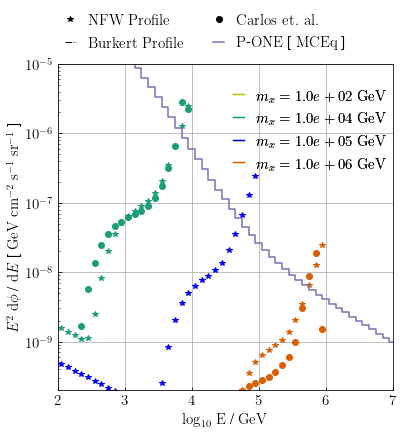

In [18]:
figure, ax1 = plt.subplots(1, 1, figsize=(std_size,std_size), sharex=True) 
#  $<\sigma\nu>=%.1e$ $cm^{3}s^{-1}$' ,sv_grid[sv_56]
#label=r'$m_{x}=1.0e+04$ $\textrm{GeV} (Carlos$ $et.al)$'
#label=r'$m_{x}=1.0e+06$ $\textrm{\textrm{\textrm{GeV}}} (Carlos$ $et.al)$'
ax1.step(np.log10(e_grid), dphi_2(e_grid),'o', color="y")
ax1.step(np.log10(e_grid), dphi_4(e_grid), 'o', color=color_4)
ax1.step(np.log10(e_grid), dphi_6(e_grid), 'o',color=color_6)
#ax1.step(e_grid, (pdm._dm_nu.extra_galactic_flux(e_grid,mass_grid[0],sv)) * e_grid**2.,'-.',
#         label=r'$m_{x}$ = %.1e , $<\sigma\nu>$ = %.1eGeV Sim'%(mass_grid[0],sv))
# burkert_flux_4 = (pdm._dm_nu.extra_galactic_flux_burkert(e_grid,mass_grid[m_4_id],sv_grid[sv_7]))# + pdm._dm_nu.galactic_flux(e_grid,mass_grid[26],sv_grid[sv_56], 2 , 2.3e23)
# burkert_flux_6 = (pdm._dm_nu.extra_galactic_flux_burkert(e_grid,mass_grid[m_6_id],sv_grid[sv_7]))# + pdm._dm_nu.galactic_flux(e_grid,mass_grid[-1],sv_grid[sv_56], 2 , 2.3e23)
nfw_flux_2 = (pdm._dm_nu.extra_galactic_flux_nfw(e_grid,mass_grid[m_2_id],sv_grid[sv_7]))
nfw_flux_3 = (pdm._dm_nu.extra_galactic_flux_nfw(e_grid,mass_grid[m_3_id],sv_grid[sv_7]))# + pdm._dm_nu.galactic_flux(e_grid,mass_grid[3],sv_grid[sv_56], 2 , 2.3e23)
nfw_flux_4 = (pdm._dm_nu.extra_galactic_flux_nfw(e_grid,mass_grid[m_4_id],sv_grid[sv_7]))# + pdm._dm_nu.galactic_flux(e_grid,mass_grid[26],sv_grid[sv_56], 2 , 2.3e23)
nfw_flux_6 = (pdm._dm_nu.extra_galactic_flux_nfw(e_grid,mass_grid[m_6_id],sv_grid[sv_7]))# + pdm._dm_nu.galactic_flux(e_grid,mass_grid[-1],sv_grid[sv_56], 2 , 2.3e23)
nfw_flux_5 = (pdm._dm_nu.extra_galactic_flux_nfw(e_grid,mass_grid[m_5_id],sv_grid[sv_7]))# + pdm._dm_nu.galactic_flux(e_grid,mass_grid[-1],sv_grid[sv_56], 2 , 2.3e23)
#ax1.step(np.log10(e_grid), burkert_flux_4 * e_grid**2., color=color_4, linestyle='-.',
#         )
ax1.step([0],[0],'*', color='k', label=r'$\textrm{NFW Profile}$' )
ax1.step([0],[0],'-.' , lw=1, color='k', label=r'$\textrm{Burkert Profile}$' )
ax1.step([0],[0],'o', color='k', label=r'$\textrm{Carlos et. al.}$' )
# ax1.step(np.log10(e_grid), burkert_flux_6 * e_grid**2., color=color_6, linestyle='-.',
#         )
ax1.step(np.log10(e_grid), nfw_flux_2 * e_grid**2., '*', color="y",
        )
ax1.step(np.log10(e_grid), nfw_flux_4 * e_grid**2., '*', color=color_4,
        )
ax1.step(np.log10(e_grid), nfw_flux_5 * e_grid**2., '*', color='b',
         )
ax1.step(np.log10(e_grid), nfw_flux_6 * e_grid**2., '*', color=color_6,
         )
ax1.step(np.log10(e_grid), (shower_po + pdm._Detector.astro_flux())*e_grid**2, color=color_pone, label=r'$\textrm{P}$-$\textrm{ONE}$ [ $\textrm{MCEq}$ ]') # Karlsruhe Corsika
# ax1.step(np.log10(e_grid), (shower_ice + pdm._Detector.astro_flux())*e_grid**2, color=color_ice, label=r'IceCube')
#ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel(r'$\log_{10}$ $\textrm{E}$ / $\textrm{GeV}$', fontsize=fontsize)
ax1.set_ylabel(r'\textbf{$E^2$} $\textrm{d}$\textbf{$\phi$} / \textrm{d}\textbf{$E$}   [ $\textrm{GeV}$ $\textrm{cm}^{-2}$ $\textrm{s}^{-1}$ $\textrm{sr}^{-1}$ ]', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.set_xlim(2, 7)
ax1.set_ylim(2e-10,1e-5)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=7, bbox_to_anchor=(0.9, +1.1),
                 ncol=2, fontsize=fontsize, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd1)
legend_elements_s = [
        Line2D([0], [0], color='y', linestyle='-', lw=1.3),
        #Line2D([0], [0], color=color_4,linestyle='-',lw=1.3),
        Line2D([0], [0], color=color_4,linestyle='-',lw=1.3),
        Line2D([0], [0], color='b', linestyle='-', lw=1.3),
        Line2D([0], [0], color=color_6, linestyle='-', lw=1.3)
                  ]
labels_s = [
        r'$m_{x}=%.1e$ $\textrm{GeV}$ ' %(mass_grid[m_2_id]),
        #r'$m_{x}=%.1e$ $\textrm{GeV}$ ' %(mass_grid[m_2_id]),
        r'$m_{x}=%.1e$ $\textrm{GeV}$ ' %(mass_grid[m_4_id]),
        r'$m_{x}=%.1e$ $\textrm{GeV}$ ' %(mass_grid[m_5_id]),
        r'$m_{x}=%.1e$ $\textrm{GeV}$ ' %(mass_grid[m_6_id])
          ]
lgd2 = ax1.legend(legend_elements_s, labels_s, loc=7, bbox_to_anchor=(1.02, +0.8),
             ncol=1, fontsize=fontsize, handlelength=h_length,
             fancybox=True, frameon=False)
ax1.add_artist(lgd2)
# ---------------------------------------------
# Showing the image
plt.grid()
plt.show()
figure.savefig(PICS + "Final_flux"+".png",
               bbox_inches='tight', dpi=export_dpi, facecolor='white')

/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:361: RuntimeWarning: overflow encountered in exp
  dd = np.exp(d_2 / s_in(x)**2)
/home/kruteesh/Desktop/DM_nu_simulation_P-One/PONE_git/pone_work/pone_dm/dm2nu.py:362: RuntimeWarning: overflow encountered in multiply
  return A * aa * dd


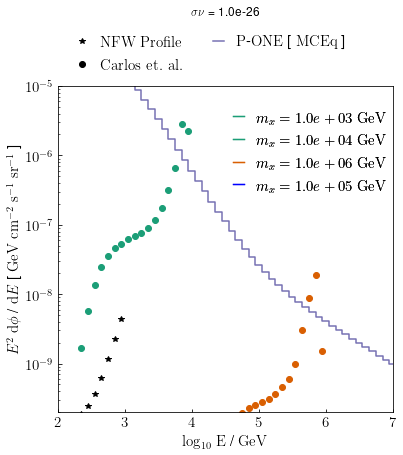

In [19]:
for sv in sv_grid:
        figure, ax1 = plt.subplots(1, 1, figsize=(std_size,std_size), sharex=True) 
        #  $<\sigma\nu>=%.1e$ $cm^{3}s^{-1}$' ,sv_grid[sv_56]
        ax1.set_title(r"$\sigma\nu$ = %.1e " % (sv), y=1.2)
        #label=r'$m_{x}=1.0e+04$ $\textrm{GeV} (Carlos$ $et.al)$'
        #label=r'$m_{x}=1.0e+06$ $\textrm{\textrm{\textrm{GeV}}} (Carlos$ $et.al)$'

        #ax1.step(e_grid, dphi_2(e_grid),'o', label=r'$m_{x}$ = 1e2 \textrm{\textrm{GeV}} Lit')

        ax1.step(np.log10(e_grid), dphi_4(e_grid), 'o', color=color_4)
        ax1.step(np.log10(e_grid), dphi_6(e_grid), 'o',color=color_6)

        #ax1.step(e_grid, (pdm._dm_nu.extra_galactic_flux(e_grid,mass_grid[0],sv)) * e_grid**2.,'-.',
        #         label=r'$m_{x}$ = %.1e , $<\sigma\nu>$ = %.1eGeV Sim'%(mass_grid[0],sv))
        # burkert_flux_4 = (pdm._dm_nu.extra_galactic_flux_burkert(e_grid,mass_grid[m_4_id], sv))# + pdm._dm_nu.galactic_flux(e_grid,mass_grid[26],sv_grid[sv_56], 2 , 2.3e23)
        # burkert_flux_6 = (pdm._dm_nu.extra_galactic_flux_burkert(e_grid,mass_grid[m_6_id], sv))# + pdm._dm_nu.galactic_flux(e_grid,mass_grid[-1],sv_grid[sv_56], 2 , 2.3e23)
        nfw_flux_3 = (pdm._dm_nu.extra_galactic_flux_nfw(e_grid,mass_grid[m_3_id], sv))# + pdm._dm_nu.galactic_flux(e_grid,mass_grid[3],sv_grid[sv_56], 2 , 2.3e23)
        nfw_flux_4 = (pdm._dm_nu.extra_galactic_flux_nfw(e_grid,mass_grid[m_4_id], sv)/1e3)# + pdm._dm_nu.galactic_flux(e_grid,mass_grid[26],sv_grid[sv_56], 2 , 2.3e23)
        nfw_flux_6 = (pdm._dm_nu.extra_galactic_flux_nfw(e_grid,mass_grid[m_6_id], sv))# + pdm._dm_nu.galactic_flux(e_grid,mass_grid[-1],sv_grid[sv_56], 2 , 2.3e23)
        nfw_flux_5 = (pdm._dm_nu.extra_galactic_flux_nfw(e_grid,mass_grid[m_5_id], sv))# + pdm._dm_nu.galactic_flux(e_grid,mass_grid[-1],sv_grid[sv_56], 2 , 2.3e23)

        #ax1.step(np.log10(e_grid), burkert_flux_4 * e_grid**2., color=color_4, linestyle='-.',
        #         )
        ax1.step([0],[0],'*', color='k', label=r'$\textrm{NFW Profile}$' )
        #ax1.step([0],[0],'-.' , lw=1, color='k', label=r'$\textrm{Burkert Profile}$' )
        ax1.step([0],[0],'o', color='k', label=r'$\textrm{Carlos et. al.}$' )
        #ax1.step(np.log10(e_grid), burkert_flux_6 * e_grid**2., color=color_6, linestyle='-.',
        #         )
        ax1.step(np.log10(e_grid), nfw_flux_3 * e_grid**2., '*', color="k",
                )
        ax1.step(np.log10(e_grid), nfw_flux_4 * e_grid**2., '*', color=color_4,
                )
        ax1.step(np.log10(e_grid), nfw_flux_5 * e_grid**2., '*', color='b',
                 )
        ax1.step(np.log10(e_grid), nfw_flux_6 * e_grid**2., '*', color=color_6,
                 )


        ax1.step(np.log10(e_grid), (shower_po + pdm._Detector.astro_flux())*e_grid**2, color=color_pone, label=r'$\textrm{P}$-$\textrm{ONE}$ [ $\textrm{MCEq}$ ]') # Karlsruhe Corsika
        # ax1.step(np.log10(e_grid), (shower_ice + pdm._Detector.astro_flux())*e_grid**2, color=color_ice, label=r'IceCube')

        #ax1.set_xscale("log")
        ax1.set_yscale("log")
        ax1.set_xlabel(r'$\log_{10}$ $\textrm{E}$ / $\textrm{GeV}$', fontsize=fontsize)
        ax1.set_ylabel(r'\textbf{$E^2$} $\textrm{d}$\textbf{$\phi$} / \textrm{d}\textbf{$E$}   [ $\textrm{GeV}$ $\textrm{cm}^{-2}$ $\textrm{s}^{-1}$ $\textrm{sr}^{-1}$ ]', fontsize=fontsize)
        ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
        ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
        ax1.set_xlim(2, 7)
        ax1.set_ylim(2e-10,1e-5)
        h, l = ax1.get_legend_handles_labels()
        lgd1 = ax1.legend(h, l, loc=7, bbox_to_anchor=(0.9, +1.1),
                         ncol=2, fontsize=fontsize, handlelength=h_length,
                         fancybox=True, frameon=False)
        ax1.add_artist(lgd1)

        legend_elements_s = [
                Line2D([0], [0], color=color_4,linestyle='-',lw=1.3),
                Line2D([0], [0], color=color_4,linestyle='-',lw=1.3),
                Line2D([0], [0], color=color_6, linestyle='-', lw=1.3),
                Line2D([0], [0], color='b', linestyle='-', lw=1.3)
                          ]
        labels_s = [r'$m_{x}=%.1e$ $\textrm{GeV}$ ' %(mass_grid[m_3_id]),
                    r'$m_{x}=%.1e$ $\textrm{GeV}$ ' %(mass_grid[m_4_id]),
                    r'$m_{x}=%.1e$ $\textrm{GeV}$ ' %(mass_grid[m_6_id]),
                    r'$m_{x}=%.1e$ $\textrm{GeV}$ ' %(mass_grid[m_5_id])
                  ]
        lgd2 = ax1.legend(legend_elements_s, labels_s, loc=7, bbox_to_anchor=(1.02, +0.8),
                     ncol=1, fontsize=fontsize, handlelength=h_length,
                     fancybox=True, frameon=False)
        ax1.add_artist(lgd2)

        # ---------------------------------------------
        # Showing the image
        plt.show()
        figure.savefig(PICS + "Final_flux"+".png",
                       bbox_inches='tight', dpi=export_dpi, facecolor='white')
        break

In [20]:
signal_ice = pickle.load(open('/home/kruteesh/Desktop/dm_data_server/28_03_desk/data/limits_signal_IceCube.pkl','rb'))
signal_com_un = pickle.load(open("../data/14_04/unsmeared/signal_grid_combined_un.pkl","rb"))
signal_pone_un = pickle.load(open("../data/14_04/unsmeared/signal_grid_POne_un.pkl","rb"))
signal_pone_sm = pickle.load(open('../data/limits_signal_POne.pkl', 'rb'))

In [21]:
#back_po = pickle.load(open('../data/background_pone_sm.pkl','rb'))
background_ic = pickle.load(open('/home/kruteesh/Desktop/dm_data_server/28_03_desk/data/background_ice.pkl','rb'))
back_ice_ob = pickle.load(open('../data/tmp_files/background_ice_data_total.pkl','rb'))
#back_comb =  pickle.load(open('../data/background_combined.pkl','rb'))
background_pone_unsm = pickle.load(open('../data/background_pone_unsm.pkl','rb'))
background_pone_sm_45_25 = pickle.load(open('../data/tmp_files/background_pone.pkl', 'rb'))
# background_pone_sm_35_15 = pickle.load(open('../data/14_04/smeared/35_15/background_pone.pkl', 'rb'))
# background_pone_sm_25_10 = pickle.load(open('../data/14_04/smeared/25_10/background_pone.pkl', 'rb'))
# background_pone_sm_15_009 = pickle.load(open('../data/14_04/smeared/15_009/background_pone.pkl', 'rb'))

In [22]:
pdm._signal_data['numu'][sv_56][0].shape

(121,)

In [23]:
mass_grid

array([1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06])

In [24]:
tmp_counts = { 0 : {"numu"}


}

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


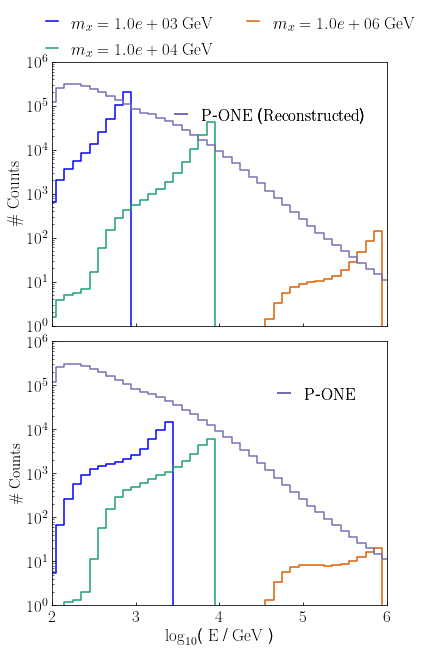

In [25]:
fig = plt.figure(figsize=(std_size,std_size+4))
gs = fig.add_gridspec(2, 1, hspace=0.06, wspace=0.05)
(ax1), (ax2) = gs.subplots( sharex=True, sharey=True)


ax1.step(np.log10(e_grid[-len(pdm._signal_data['numu'][sv_56][m_3_id]):]), pdm._signal_data['numu'][sv_56][m_3_id], color='b', linestyle='-',
         label=r'$m_{x}=%.1e$ $\textrm{GeV}$' % (mass_grid[m_3_id]))
ax1.step(np.log10(e_grid[-len(pdm._signal_data['numu'][sv_56][0]):]), pdm._signal_data["numu"][sv_56][m_4_id], color=color_4, linestyle='-',
         label=r'$m_{x}=%.1e$ $\textrm{GeV}$' % (mass_grid[m_4_id]))
ax1.step(np.log10(e_grid[-len(pdm._signal_data['numu'][sv_56][0]):]), pdm._signal_data["numu"][sv_56][m_6_id], color=color_6, linestyle='-',
         label=r'$m_{x}=%.1e$ $\textrm{GeV}$' % (mass_grid[m_6_id]))



ax2.step(np.log10(e_grid[-len(signal_pone_sm['numu'][6][0]):]), signal_pone_un["numu"][6][3], color='b', linestyle='-')#,
         #label=r'$m_{x}=%.1e$ $GeV$' % (mass_grid[2]))
ax2.step(np.log10(e_grid[-len(signal_pone_sm['numu'][6][0]):]), signal_pone_un["numu"][6][4], color=color_4, linestyle='-')#,
         #label=r'$m_{x}=%.1e$ $GeV$' % (mass_grid[4]))
ax2.step(np.log10(e_grid[-len(signal_pone_sm['numu'][6][0]):]), signal_pone_un["numu"][6][-1], color=color_6, linestyle='-')#,
         #label=r'$m_{x}=%.1e$ $GeV$' % (mass_grid[-1]))

ax1.step(np.log10(e_grid), background_pone_sm_45_25['numu'], '-', color=color_pone)

ax2.step(np.log10(e_grid), background_pone_unsm['numu'], '-', color=color_pone)

ax1.set_yscale("log")
#ax1.set_xlabel(r'$\log_{10}$( E / $GeV$ )', fontsize=fontsize+6)
ax1.set_ylabel(r'$ \#$  $\textrm{Counts}$', fontsize=fontsize+2)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize+2, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize+2, direction='in')
ax1.set_xlim(2, 6)
ax1.set_ylim(1e0,1e6)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=7, bbox_to_anchor=(1.13, +1.1),
                 ncol=2, fontsize=fontsize+2, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd1)

#ax2.set_xscale("log")
ax2.set_yscale("log")
#ax2.set_xlabel(r'$\log_{10}$( E / $GeV$ )', fontsize=fontsize+6)
ax2.set_ylabel(r'$\#$  $\textrm{Counts}$', fontsize=fontsize)
ax2.tick_params(axis = 'both', which = 'major', labelsize=fontsize+2, direction='in')
ax2.tick_params(axis = 'both', which = 'minor', labelsize=fontsize+2, direction='in')
ax2.set_xlim(2, 6)
ax2.set_ylim(1e0,1e6)

ax2.set_xlabel(r'$\log_{10}$( $\textrm{E}$ / $\textrm{GeV}$ )', fontsize=fontsize+2)
h = [Line2D([0], [0], color=color_pone,lw=2)]
l = [r'$\textrm{P}$-$\textrm{ONE}$'
          ]
lgd1 = ax2.legend(h, l, loc=7, bbox_to_anchor=(0.95, +0.8),
                 ncol=2, fontsize=fontsize+2, handlelength=h_length,
                 fancybox=True, frameon=False)
ax2.add_artist(lgd1)
h_i = [Line2D([0], [0], color=color_pone ,lw=2)]
l_i = [r'$\textrm{P}$-$\textrm{ONE}$ ($\textrm{Reconstructed}$)'
          ]
lgd2 = ax1.legend(h_i, l_i, loc=7, bbox_to_anchor=(0.98, +0.8),
                 ncol=2, fontsize=fontsize+2, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd2)

plt.show()
fig.savefig(PICS + "Final_signal"+".png",
               bbox_inches='tight', dpi=export_dpi, facecolor='white')

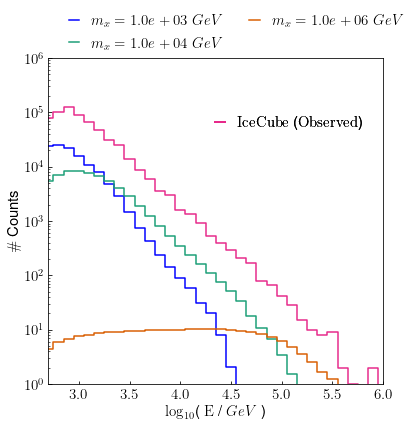

In [26]:
figure, ax1 = plt.subplots(1, 1, figsize=(std_size,std_size), sharex=True) 

#ax1.step(e_grid[-len(pdm._signal_data[-1][-1]):],


ax1.step(np.log10(e_grid[-len(signal_ice[sv_56][0]):]), signal_ice[sv_56][m_3_id], color='b', linestyle='-',
         label=r'$m_{x}=%.1e$ $GeV$' % (mass_grid[m_3_id]))
ax1.step(np.log10(e_grid[-len(signal_ice[sv_56][0]):]), signal_ice[sv_56][m_4_id], color=color_4, linestyle='-',
         label=r'$m_{x}=%.1e$ $GeV$' % (mass_grid[m_4_id]))
ax1.step(np.log10(e_grid[-len(signal_ice[sv_56][0]):]), signal_ice[sv_56][m_6_id], color=color_6, linestyle='-',
         label=r'$m_{x}=%.1e$ $GeV$' % (mass_grid[m_6_id]))
ax1.step(np.log10(e_grid)[:-1], back_ice_ob, color=color_ice, linestyle='-')

#ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel(r'$\log_{10}$( \textrm{E} / $GeV$ )', fontsize=fontsize)
ax1.set_ylabel(r'$ \#$  Counts', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')

ax1.set_xlim(2.7, 6.0)
ax1.set_ylim(1e0,1e6)

# ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
# ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=7, bbox_to_anchor=(1.090, +1.08),
                 ncol=2, fontsize=fontsize, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd1)

h_i = [Line2D([0], [0], color=color_ice ,lw=2)]
l_i = [r'$\textrm{IceCube}$ ($\textrm{Observed}$)'
          ]
lgd2 = ax1.legend(h_i, l_i, loc=7, bbox_to_anchor=(0.98, +0.8),
                 ncol=2, fontsize=fontsize, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd2)
# ---------------------
# ---------------------------------------------
# Showing the image
plt.show()
figure.savefig(PICS + "Final_signal_ice"+".png",
                bbox_inches='tight', dpi=export_dpi, facecolor='white')

In [27]:
flux={}
flux[15]={}
flux[85]={}
flux[120]={}
flux[15]['numu'] = (dphi_4(e_grid)) * e_grid**(-2)
flux[85]['numu'] = flux[15]['numu']
flux[120]['numu'] = flux[15]['numu']
flux[15]['nue']=flux[85]['nue']=flux[120]['nue']=flux[15]['nutau']=flux[85]['nutau']=flux[120]['nutau']=flux[15]['numu']
#_lit=pdm._Detector.sim2dec(flux,True)["numu"]


In [28]:
# Loading comparison data
th_cl = np.loadtxt(open("../data/thermal_relic.csv"), delimiter = ",")
unitarity = np.loadtxt(open('../data/Unitarity_bound.csv'), delimiter = ',')
cl_lit = np.loadtxt('../data/CL_PONE.csv', delimiter=",")
cl_lit = (cl_lit[cl_lit[:, 0].argsort()])
unitarity = (unitarity[unitarity[:, 0].argsort()])

#limits_ice = pickle.load(open('/home/kruteesh/Desktop/dm_data_server/28_03_desk/data/limits_results_IceCube.pkl','rb'))
limits_pone_unsm = pickle.load(open("../data/nfw_unsmea_limits.pkl","rb"))
#limits_com = pickle.load(open("/home/kruteesh/Desktop/dm_data_server/14_03/data/limits_results.pkl", "rb"))
#limits_pone_unsm = pickle.load(open("../data/28_03_02/unsmeared/limits_results_POne_unsm.pkl","rb"))

limits_pone_45_25= pickle.load(open("../data/14_04/smeared/45_25/limits_results_POne_sm_NFW.pkl","rb"))

limits_pone_35_15= pickle.load(open("../data/14_04/smeared/35_15/limits_results_POne_sm.pkl","rb"))

limits_pone_25_10= pickle.load(open("../data/14_04/smeared/25_10/limits_results_POne_sm.pkl","rb"))

limits_pone_15_009= pickle.load(open("../data/14_04/smeared/15_009/limits_results_POne_sm.pkl","rb"))


cl_lit_ice = np.loadtxt('../data/IceCube_HE.csv', delimiter=",")
cl_lit_ice = (cl_lit_ice[cl_lit_ice[:, 0].argsort()])
xx,yy = np.meshgrid(np.log10( np.logspace(1, 6, 20)),np.log10( np.logspace(1, 6, 20)))

In [29]:
pdm.results

{'numu': array([[1.00000000e+000, 1.00000000e+000, 9.99662752e-001,
         9.99734563e-001, 9.99837301e-001, 9.99908943e-001,
         9.99961108e-001, 9.99989565e-001, 9.99998370e-001],
        [1.00000000e+000, 1.00000000e+000, 9.94019727e-001,
         9.95290282e-001, 9.97110703e-001, 9.98381981e-001,
         9.99308611e-001, 9.99814448e-001, 9.99971010e-001],
        [1.00000000e+000, 1.00000000e+000, 8.98826527e-001,
         9.19477419e-001, 9.49847204e-001, 9.71614463e-001,
         9.87776251e-001, 9.96705493e-001, 9.99484608e-001],
        [1.00000000e+000, 1.00000000e+000, 1.50047144e-001,
         2.24728589e-001, 4.00517242e-001, 5.99249747e-001,
         8.03553202e-001, 9.43006352e-001, 9.90874415e-001],
        [1.00000000e+000, 1.00000000e+000, 2.24402340e-015,
         2.95578933e-012, 8.58015063e-008, 1.10980417e-004,
         2.04594910e-002, 3.52207582e-001, 8.49571321e-001],
        [1.00000000e+000, 1.00000000e+000, 3.16472615e-261,
         9.47022562e-206, 2

# Fill through function for the band between smeared and unsmeared combined limits !!!!!!!! 

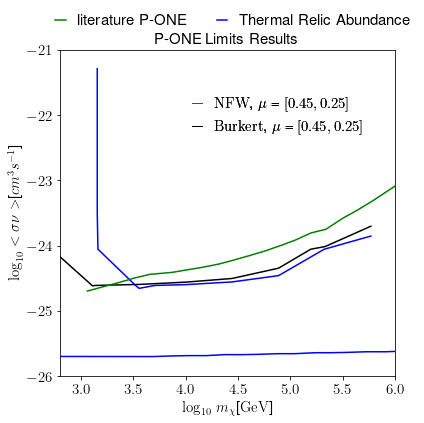

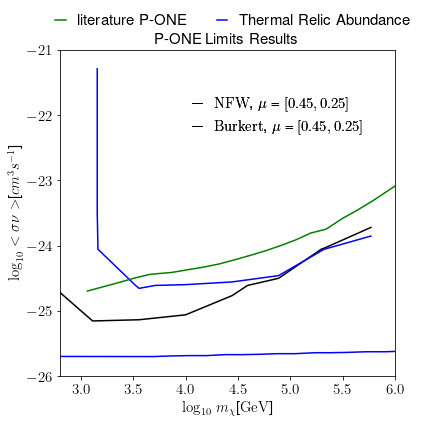

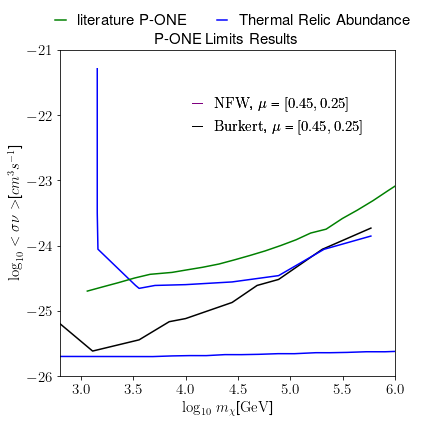

In [30]:
color = ['black', 'orange', 'purple']
color_sm = ['red', 'black', 'purple']
color_pa = ['']
color_pa = ['']
color_pa = ['']
color_pa = ['']

ll = ['-','--', '-.', 'dotted']
 # std_size, std_size * 6. / 8.),
for j,i in enumerate(config["pone"]["specific particle scaling"].keys()):
    # Limits
    # ---------------------------------------------
    # Setup

    figure, (ax1) = plt.subplots(1, 1, figsize=(std_size,std_size), sharex=True) 
    # ---------------------------------------------
    # Plotting
    plt.title('P-ONE Limits Results',fontsize=fontsize)  # +' Scaling Correction = '+str(config['advanced']['scaling correction'])
    
    ax1.contour(pdm.results[i], levels = [0.9], colors='k',  linestyles='-',
               origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                       min(np.log10(sv_grid)), max(np.log10(sv_grid))))
    
    ax1.contour(limits_pone_unsm['numu'], levels = [0.9], colors="b",  linestyles=ll[0],
                origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                        min(np.log10(sv_grid)), max(np.log10(sv_grid))))
# 
    #ax1.contour(limits_pone_45_25['numu'], levels = [0.9], colors=color_sm[j],  linestyles=ll[0],
    #             origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
    #                                     min(np.log10(sv_grid)), max(np.log10(sv_grid))))
    #ax1.contour(limits_pone_35_15[i], levels = [0.9], colors=color_sm[j],  linestyles=ll[1],
    #             origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
    #                                     min(np.log10(sv_grid)), max(np.log10(sv_grid))))
    # ax1.contour(limits_pone_25_10[i], levels = [0.9], colors=color_sm[j],  linestyles=ll[2],
    #             origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
    #                                     min(np.log10(sv_grid)), max(np.log10(sv_grid))))
    # ax1.contour(limits_pone_15_009[i], levels = [0.9], colors=color_sm[j],  linestyles=ll[3],
    #             origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
    #                                     min(np.log10(sv_grid)), max(np.log10(sv_grid))))

    #break
    #ax1.contour(limits_ice["numu"], levels=[0.9], colors='yellow',origin='lower',linestyles='-',
    #                            extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
    #                                    min(np.log10(sv_grid)), max(np.log10(sv_grid))))#
    #ax1.contour(limits_pone_unsm["numu"], levels=[0.9], colors='green',origin='lower',linestyles='-.',
    #                            extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
    #                                    min(np.log10(sv_grid)), max(np.log10(sv_grid))))
    ax1.plot(np.log10(cl_lit[:, 0]), np.log10(cl_lit[:, 1]), 'g', label='literature P-ONE')
    #ax1.plot(np.log10(cl_lit_ice[:, 0]), np.log10(cl_lit_ice[:, 1]),'m',label='literature  IceCube')
    ax1.plot(np.log10(th_cl[:, 0]), np.log10(th_cl[:, 1]), 'b', 
             label='Thermal Relic Abundance')
    #ax1.plot(np.log10(unitarity[:, 0]), np.log10(unitarity[:, 1]), '.k', 
    #         label='Unitarity Bound')
    # ---------------------------------------------
    # Axis options
    ax1.set_xscale("linear")
    ax1.set_yscale("linear")
    ax1.set_xlabel(r"$\log_{10}$ $m_{\chi}$[\textrm{GeV}]", fontsize=fontsize)
    ax1.set_ylabel(r"$\log_{10}$ $<\sigma \nu>$[$cm^{3} s^{-1}$]", fontsize=fontsize)
    ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize)
    ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize)
    ax1.set_xlim(2.8, max(np.log10(mass_grid)))
    ax1.set_ylim(min(np.log10(sv_grid)), -21)  # 
    #ax1.text(3.5, -23.7, "IceCube Simulation", fontsize=fontsize)

    #ax1.text(3.2, -24.8, r"P-ONE $\nu_\mu$", fontsize=fontsize)
    #ax1.text(3.2, -24.9, r" $\nu_e$", fontsize=fontsize)
    #ax1.text(3.1, -25.3, r" $\nu_\tau$", fontsize=fontsize)

    # ---------------------------------------------
    # Legend
    # plt.legend(fontsize=fontsize)
    h, l = ax1.get_legend_handles_labels()
    lgd1 = ax1.legend(h, l, loc=7, bbox_to_anchor=(1.09, +1.09),
                     ncol=2, fontsize=fontsize, handlelength=h_length,
                     fancybox=True, frameon=False)
    ax1.add_artist(lgd1)
    legend_elements = [Line2D([0], [0], color=color_sm[j], lw=1),
                   #Line2D([0], [0], linestyle='--', color=color_sm[j],  lw=1),
                   Line2D([0], [0], color="k", lw=1)
                   #Line2D([0], [0], linestyle='-.', color=color_sm[j],  lw=1.3),
                   #Line2D([0], [0], linestyle=':',  color=color_sm[j], lw=1),
                   #Line2D([0], [0], color=color_sm[j], linestyle='dotted', lw=2),
                  ]
    labels = [r'$\textrm{NFW}$, $\mu$ = $[0.45, 0.25]$',
           #r'$\textrm{NFW}$, $\mu$ = [$0.35, 0.15$]',
           r'$\textrm{Burkert}$, $\mu$ = $[0.45, 0.25]$',
           #r'0.15, 0.09'
           ]
    lgd2 = ax1.legend(legend_elements, labels, loc=7, bbox_to_anchor=(0.95, +0.799),
                     ncol=1, fontsize=fontsize, handlelength=h_length,
                     fancybox=True, frameon=False)
    ax1.add_artist(lgd2)
    # #h, _ = ax1.get_legend_handles_labels([legend_elements])
    #lgd2= ax1.legend(h, labels, loc=7, bbox_to_anchor=(1, 0.8),
    #                 ncol=1, fontsize=fontsize, handlelength=h_length,
    #                 fancybox=True, frameon=False)
    #ax1.add_artist(lgd2)

    # ---------------------------------------------
    # Showing the image
    plt.show()
    # ---------------------------------------------
    # Storing the image
    figure.savefig(PICS + "Limits_Example_all_%s.png" %(i),
               bbox_inches='tight', dpi=export_dpi,  facecolor='white')


In [31]:
# pickle.dump(pdm.results, open('../data/nfw_unsmea_limits.pkl', 'wb'))


NameError: name 'limits_ice' is not defined

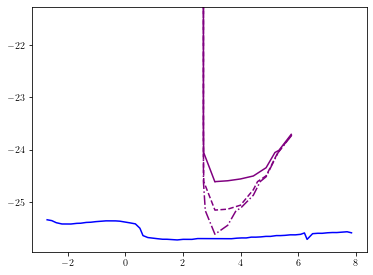

In [32]:
# All Limits-------------------------------------------
# Setup
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
# ---------------------------------------------
# Plotting
ax1.contour(pdm.results["numu"], levels = [0.9], colors='purple', linestyles='-',
            origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                    min(np.log10(sv_grid)), max(np.log10(sv_grid))))
ax1.contour(pdm.results["nue"], levels = [0.9], colors='purple', linestyles='--',
            origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)), 
                                    min(np.log10(sv_grid)), max(np.log10(sv_grid))))
ax1.contour(pdm.results["nutau"], levels = [0.9], colors='purple', linestyles='-.',
            origin='lower', extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                    min(np.log10(sv_grid)), max(np.log10(sv_grid))))
#ax1.plot(np.log10(cl_lit[:, 0]), np.log10(cl_lit[:, 1]), 'g', label='literature 90% C.L')
ax1.plot(np.log10(th_cl[:, 0]), np.log10(th_cl[:, 1]), 'b', 
         label='literature Thermal Relic Abundance')
ax1.contour(limits_ice["numu"], levels=[0.9], colors='red',origin='lower',
                                extent=(min(np.log10(mass_grid)), max(np.log10(mass_grid)),
                                        min(np.log10(sv_grid)), max(np.log10(sv_grid))), legend='IceCube')
ax1.plot(np.log10(cl_lit[:, 0]), np.log10(cl_lit[:, 1]), 'g', label='literature 90% C.L P-ONE')
ax1.plot(np.log10(cl_lit_ice[:, 0]), np.log10(cl_lit_ice[:, 1]), label='literature 90% C.L IceCube')
# ---------------------------------------------
# Axis options
ax1.set_xscale("linear")
ax1.set_yscale("linear")
ax1.set_xlabel(r"log $m_{\chi}$", fontsize=fontsize)
ax1.set_ylabel(r"log <$\sigma\nu$>", fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize-5, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize-5, direction='in')
ax1.set_xlim(min(np.log10(mass_grid)), max(np.log10(mass_grid)))
ax1.set_ylim(min(np.log10(sv_grid)),-23.0)
# ---------------------------------------------
# Legend
# plt.legend(fontsize=fontsize)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=9, bbox_to_anchor=(0.4, +1.),
                 ncol=1, fontsize=fontsize-3, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd1)
# ---------------------------------------------
ax1.text(3.5, -23.7, "IceCube", fontsize=fontsize)
ax1.text(3.4, -24.4, "P-ONE", fontsize=fontsize)
ax1.text(3.2, -24.3, r"$\nu_\mu$", fontsize=fontsize)
ax1.text(3.2, -24.9, r"$\nu_e$", fontsize=fontsize)
ax1.text(3.1, -25.3, r"$\nu_\tau$", fontsize=fontsize)
ax1.text(4.2, -25.5, "Thermal Relic Abundance", fontsize=fontsize)
plt.grid()
# ---------------------------------------------
# Showing the image
plt.show()
# ---------------------------------------------
# Storing the image
figure.savefig(PICS + "All_Limits.png",
               bbox_inches='tight', dpi=export_dpi)

In [ ]:
samples = np.random.lognormal(4, 0.3 * 4., 1000)
count, bins, ignored = plt.hist(samples, 100, density=False, align='mid')

In [ ]:
mid_e_grid = np.logspace(3, 4, 100)

In [ ]:
spl_mid_mean = UnivariateSpline([1e3, 1e4], [700., 1e4], k=1)
spl_mid_sigma = UnivariateSpline([1e3, 1e4], [0.45, 0.35], k=1)

In [ ]:
def local_log_normal(x, mu, sigma):
    """Distribution function 
    x = E_grid
    mu = log(E) 
    sigma = fraction of E  ( so no fraction or percentage ) ( standard deviation as per definition )
    """
    sigma = ( sigma  )
    pdf = np.exp(-(np.log((x)) - mu )**2 / (2 * sigma**2)) / ( sigma * np.sqrt(2 * np.pi))

    return pdf

In [ ]:
def _log_norm(E, mu, sigma):
    """Distribution function
    x = E_grid
    mu = log(E)
    sigma = fraction of E * E ( so no fraction or percentage )
    ( standard deviation as per definition )
    """
    pdf = (np.exp(- (np.log((E)) - mu)**2 / (2 * sigma**2)) /
           (sigma * np.sqrt(2 * np.pi)))
    return pdf

In [ ]:
def distro_parms(Etrue):
    """ Parameter estimation function depending  on the E_true
    [mu] = [log10(E/GeV)]
    sigma = log10(E/GeV)
    """
    if Etrue < 1e3:
        mu = np.log(700)
        sigma = 0.45 
    elif 1e3 <= Etrue <= 1e4:
        mu = np.log(spl_mid_mean(Etrue))
        sigma = spl_mid_sigma(Etrue) 
    else:
        mu = np.log(Etrue)
        sigma = 0.35 
    return mu, sigma


#def smearing(Etrue, number_of_events, sampling_grid=hist_grid):
#    mu, sigma = distro_parms(Etrue)
#    return (
#        np.nan_to_num(local_log_normal(sampling_grid, mu, sigma)) *
#        number_of_events
#    )


In [ ]:
samples_fun = []
samples = []
samples_fun_log = []
for i,E in enumerate(e_grid):
    mu, sigma = distro_parms(E)
    samples.append(np.random.lognormal((mu), sigma, len(e_grid))) # Axis0 = E, meaning the axis0 elements are the E_ture for which axis1 correspondece as distribution !!! Thats why transpose for imshow
    samples_fun.append(np.nan_to_num(local_log_normal(e_grid, mu, sigma)))
    samples_fun_log.append(np.nan_to_num(_log_norm(e_grid, mu, sigma))* np.log10(pdm._shower_sim.ewidth))
    

In [ ]:
from matplotlib.colors import LogNorm

In [ ]:
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6./8. ), sharex=True)
z_p=ax1.imshow((np.array(samples_fun).T), origin='lower', extent=( min(np.log10(e_grid)), max(np.log10(e_grid)), min(np.log10(e_grid)), max(np.log10(e_grid)) ),
               cmap=plt.get_cmap('bone'))
#figure.colorbar(z_p, ax=(ax1))
ax1.contour(np.array(samples_fun).T, levels = [0.00000008], colors='red', linestyles='-',
            origin='lower', extent=( min(np.log10(e_grid)), max(np.log10(e_grid)), min(np.log10(e_grid)), max(np.log10(e_grid))) )
#ax1.contour(np.array(samples).T, levels = [0.68], colors='purple', linestyles='-',
#           origin='lower', extent=( min(np.log10(e_grid)), max(np.log10(e_grid)), min(np.log10(e_grid)), max(np.log10(e_grid))), norm=LogNorm() )
#ax1.contour((samples_fun*e_grid).T, levels = [1.2], colors='purple', linestyles='-',
#            origin='lower', extent=( min(np.log10(e_grid)), max(np.log10(e_grid)), min(np.log10(e_grid)), max(np.log10(e_grid))) )
figure.colorbar(z_p, ax=(ax1))

ax1.set_xlabel(r"$\log_{10}$ $E_{true} / \textrm{GeV}$", fontsize=fontsize)
ax1.set_ylabel(r"$\log_{10}$ $E_{Recon} / \textrm{GeV}$", fontsize=fontsize)
#ax1.set_ylabel(r"Distribution fraction", fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.set_xlim(2,8)
ax1.set_ylim(2,8)
# ---------------------------------------------
# Legend
# plt.legend(fontsize=fontsize)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=9, bbox_to_anchor=(0.4, +1.),
                 ncol=1, fontsize=fontsize, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd1)
plt.grid()
figure.savefig(PICS + "Reconstruction_"+".png",
               bbox_inches='tight', dpi=export_dpi, facecolor='white')


In [ ]:
cmap_string= ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2',
'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r',
'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 
'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 
'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 
'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 
'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 
'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 
'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink',
'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 
'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 
'winter', 'winter_r']


In [ ]:
for i,_ in enumerate(e_grid):
    print(np.trapz(samples_fun[i], x=e_grid))

In [ ]:
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6./8. ), sharex=True)
ax1.imshow((count_np*e_grid).T, origin='lower', extent=( min(np.log10(e_grid)), max(np.log10(e_grid)), min(np.log10(e_grid)), max(np.log10(e_grid)) ))
ax1.set_xlabel(r"log $E_{true}$", fontsize=fontsize)
ax1.set_ylabel(r"log $E_{Recon}$", fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize-5, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize-5, direction='in')

# ---------------------------------------------
# Legend
# plt.legend(fontsize=fontsize)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=9, bbox_to_anchor=(0.4, +1.),
                 ncol=1, fontsize=fontsize-3, handlelength=h_length,
                 fancybox=True, frameon=False)
ax1.add_artist(lgd1)

plt.grid()

In [ ]:
np.array(count_np).shape

In [ ]:
count_np